#### GP regression is a non-parametric approach to reconstructing observational data which are incorporated as a finite collection of normally distributed points. This type of supervised learning is implemented for stochastic data whose data points are related together enough such that a covariance function can be fit in such a way as to prescribe these relations in a specific way. In practice a GP is defined in terms of the mean function $\mu(z)$ together with its associated two-point covariant function $\mathcal{C}(z,\tilde{z})$ which produces the continuous realization
\begin{equation}
	\xi(z)\sim\mathcal{GP}\left(\mu(z),\mathcal{C}(z,\tilde{z})\right)\,,
\end{equation}
where the uncertainty $\Delta\xi(z)$ is also part of the reconstruction which produces a realization region $\xi(z) \pm \Delta \xi(z)$. By and large the mean is set to zero without loss of generality so that the covariance function becomes the defining feature for each reconstructed data set. For redshift points $z^*$ which represent points where observations do not occur, we can define a kernel function for the covariance function such that $\mathcal{K}\left(z^*,z^{*'}\right) = \mathcal{C}\left(z^*,z^{*'}\right)$ where the trained covariance function is utilised. Thus, the kernel will embody all the information about the strength and amplitude of the correlations between the redshift data points. The only strong requirement on the kernel is that it is a symmetric function.

For observational point $\tilde{z}$, we also have available to us information on the associated uncertainty region covariance matrix $\mathcal{D}\left(\tilde{z},\tilde{z}'\right)$ between data points. Thus, the covariance function for these points can be written as $\mathcal{C}\left(\tilde{z},\tilde{z}'\right) = \mathcal{K}\left(\tilde{z},\tilde{z}'\right) + \mathcal{D}\left(\tilde{z},\tilde{z}'\right)$ which will provide information to fit the kernel. Naturally, observational and reconstructed points can be interrelated by the kernel alone through $\mathcal{C}\left(z^*,\tilde{z}'\right) = \mathcal{K}\left(z^*,\tilde{z}'\right)$.

Therefore, for a Gaussian distribution, the posterior distribution of a reconstructed function can be expressed via the joint Gaussian distribution of different data points in which the kernel expresses the interrelated mean value and uncertainties of each point in the resulting distribution.

We use the squared-exponential kernel but there exist a plethora of such kernel options. Despite each producing a slightly different non-parametric reconstruction of a distribution, they largely agree to well within $1\sigma$ confidence regions. The general purpose squared-exponential kernel is explicitly defined as
\begin{equation}
	\mathcal{K}\left(z,\tilde{z}\right) = \sigma_f^2 \exp\left[-\frac{\left(z-\tilde{z}\right)^2}{2l_f^2}\right]\,,
\end{equation}
where $\sigma_f$ and $l_f$ are the kernel hyperparameters, which are parameters of the kernel but do not parameterise the function being reconstructed, as a model would. The hyperparameters characterise the variance in the data through $\sigma_f$ and the length-scale through $l_f$. Thus, the hyperparameters define the smoothness and reach for fluctuations in a signal. As a result, larger values of $l_f$ lead to smoother GP functions while higher values of $\sigma_f$ express a lower signal-to-noise ratio.

To determine the best suited hyperparameters, their values are derived from the maximisation of the probability of the GP to generate the data set under consideration which is implemented via the minimisation of the GP marginal likelihood similar to a Bayesian approach.

GP regression has now been extensively studied as a tool for reconstructions in the cosmological context which have largely focused on the late-time behaviour of the expansion rate.

#### We will be applying GPyTorch which is a Gaussian process library implemented using PyTorch. GPyTorch is designed for creating scalable, flexible, and modular Gaussian process models with ease.

#### Internally, GPyTorch differs from many existing approaches to GP inference by performing most inference operations using numerical linear algebra techniques like preconditioned conjugate gradients. Implementing a scalable GP method is as simple as providing a matrix multiplication routine with the kernel matrix and its derivative via our LinearOperator interface, or by composing many of our already existing LinearOperators. This allows not only for easy implementation of popular scalable GP techniques, but often also for significantly improved utilization of GPU computing compared to solvers based on the Cholesky decomposition.


https://pypi.org/project/gpytorch/

Gardner, Jacob R., Geoff Pleiss, David Bindel, Kilian Q. Weinberger, and Andrew Gordon Wilson. "GPyTorch: Blackbox Matrix-Matrix Gaussian Process Inference with GPU Acceleration." In Advances in Neural Information Processing Systems (2018). https://arxiv.org/abs/1809.11165

https://gpytorch.ai/

In [4]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.6 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Corfu_Lectures/

/content/drive/MyDrive/Corfu_Lectures


In [7]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [ ]:
# Load JLA data set
jla_data = pd.read_csv('data/JLA.csv')

# Load mb and corresponding errors
train_y = torch.tensor(jla_data['mb'].values)
y_err = torch.tensor(jla_data['errors'].values)

# Load redshifts
train_x = torch.tensor(jla_data['zcmb'].values)

## Setting up the model

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.

2. A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.

3. A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)

4. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).

5. A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

## Training the model

In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients

2. Call the model and compute the loss

3. Call backward on the loss to fill in gradients

4. Take a step on the optimizer

## **Matern kernel**

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=1))

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1.3, 200)
    observed_pred = likelihood(model(test_x))

Iter 1/200 - Loss: 1.705
Iter 2/200 - Loss: 1.613
Iter 3/200 - Loss: 1.532
Iter 4/200 - Loss: 1.461
Iter 5/200 - Loss: 1.397
Iter 6/200 - Loss: 1.337
Iter 7/200 - Loss: 1.279
Iter 8/200 - Loss: 1.221
Iter 9/200 - Loss: 1.165
Iter 10/200 - Loss: 1.110
Iter 11/200 - Loss: 1.056
Iter 12/200 - Loss: 1.004
Iter 13/200 - Loss: 0.954
Iter 14/200 - Loss: 0.906
Iter 15/200 - Loss: 0.861
Iter 16/200 - Loss: 0.819
Iter 17/200 - Loss: 0.780
Iter 18/200 - Loss: 0.743
Iter 19/200 - Loss: 0.710
Iter 20/200 - Loss: 0.679
Iter 21/200 - Loss: 0.652
Iter 22/200 - Loss: 0.628
Iter 23/200 - Loss: 0.607
Iter 24/200 - Loss: 0.588
Iter 25/200 - Loss: 0.573
Iter 26/200 - Loss: 0.560
Iter 27/200 - Loss: 0.550
Iter 28/200 - Loss: 0.542
Iter 29/200 - Loss: 0.536
Iter 30/200 - Loss: 0.530
Iter 31/200 - Loss: 0.525
Iter 32/200 - Loss: 0.520
Iter 33/200 - Loss: 0.515
Iter 34/200 - Loss: 0.509
Iter 35/200 - Loss: 0.502
Iter 36/200 - Loss: 0.495
Iter 37/200 - Loss: 0.487
Iter 38/200 - Loss: 0.479
Iter 39/200 - Loss: 0

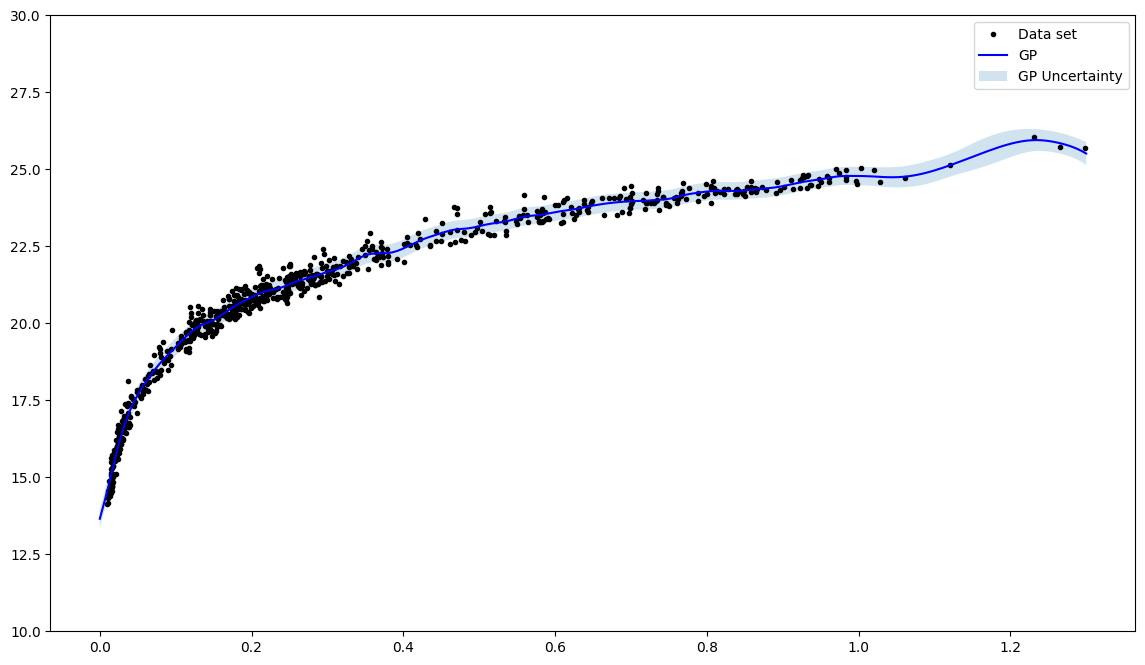

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(), observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## RBF Kernel

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1.3, 200)
    observed_pred = likelihood(model(test_x))

Iter 1/200 - Loss: 1.857
Iter 2/200 - Loss: 1.788
Iter 3/200 - Loss: 1.715
Iter 4/200 - Loss: 1.638
Iter 5/200 - Loss: 1.562
Iter 6/200 - Loss: 1.493
Iter 7/200 - Loss: 1.435
Iter 8/200 - Loss: 1.384
Iter 9/200 - Loss: 1.334
Iter 10/200 - Loss: 1.286
Iter 11/200 - Loss: 1.239
Iter 12/200 - Loss: 1.192
Iter 13/200 - Loss: 1.143
Iter 14/200 - Loss: 1.091
Iter 15/200 - Loss: 1.039
Iter 16/200 - Loss: 0.992
Iter 17/200 - Loss: 0.951
Iter 18/200 - Loss: 0.914
Iter 19/200 - Loss: 0.878
Iter 20/200 - Loss: 0.845
Iter 21/200 - Loss: 0.818
Iter 22/200 - Loss: 0.795
Iter 23/200 - Loss: 0.775
Iter 24/200 - Loss: 0.758
Iter 25/200 - Loss: 0.743
Iter 26/200 - Loss: 0.730
Iter 27/200 - Loss: 0.719
Iter 28/200 - Loss: 0.709
Iter 29/200 - Loss: 0.698
Iter 30/200 - Loss: 0.687
Iter 31/200 - Loss: 0.675
Iter 32/200 - Loss: 0.662
Iter 33/200 - Loss: 0.649
Iter 34/200 - Loss: 0.636
Iter 35/200 - Loss: 0.624
Iter 36/200 - Loss: 0.614
Iter 37/200 - Loss: 0.604
Iter 38/200 - Loss: 0.596
Iter 39/200 - Loss: 0

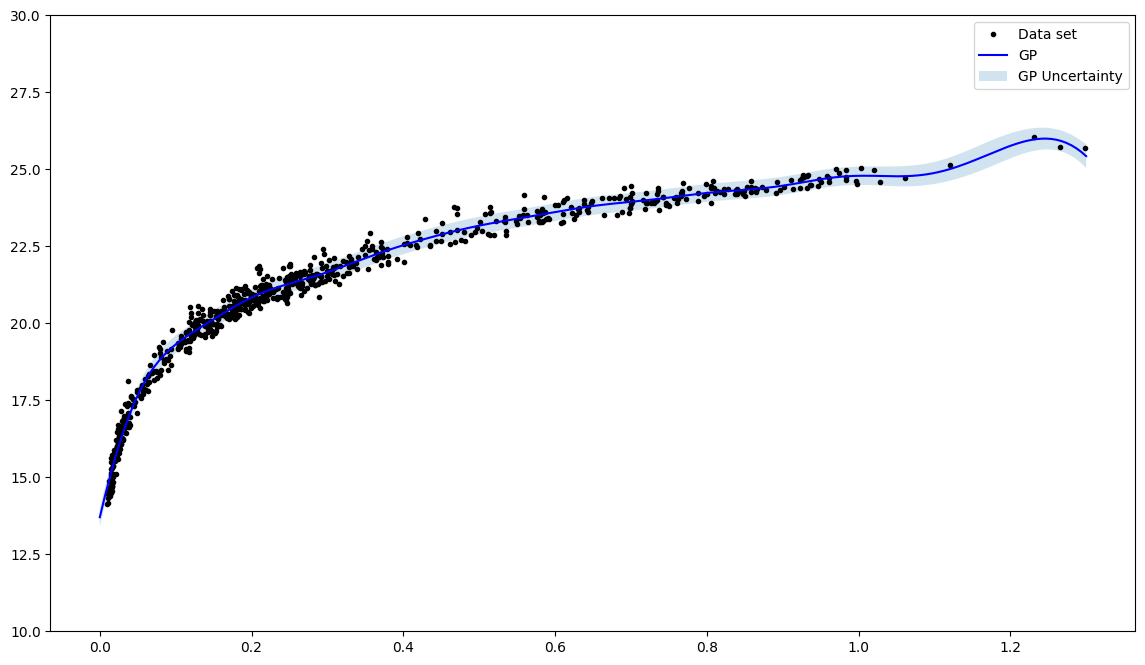

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(), observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## Pantheon+

## Implement the same GP algorithms to the Pantheon+ data sets which should be downloaded from https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR

## -> Pantheon+SH0ES.dat
## -> Pantheon+SH0ES_STAT+SYS.cov

In [ ]:
import numpy as np

In [ ]:
PN_data = 'data/Pantheon+SH0ES.dat'
syscov_file = 'data/Pantheon+SH0ES_STAT+SYS.cov'
df = pd.read_csv(PN_data, sep = " ")
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [ ]:
sq_errors = np.diag(syscov)
df['errors'] = np.sqrt(sq_errors)
df.describe()

,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,...,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD,errors
count,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.00000,1701.000000,1701.000000,1701.000000,1701.000000,...,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000
mean,37.017637,0.221229,0.001840,0.221090,0.001155,0.22143,0.001155,19.083629,0.240920,38.336629,...,36.499118,47.227484,0.469040,0.104899,0.061886,-0.009629,0.004541,0.972350,0.008889,0.169411
std,45.916840,0.249271,0.002593,0.249337,0.002774,0.24944,0.002774,3.374499,0.098815,3.374499,...,23.891781,67.434767,0.378961,0.055224,0.096221,0.074649,0.005048,0.089824,0.009789,0.059434
min,1.000000,0.001220,0.000840,0.001220,0.000000,0.00082,0.000000,9.745710,0.111583,28.998700,...,0.000000,0.219440,0.000000,0.034300,0.004300,-0.535600,0.000000,0.164000,0.000000,0.080278
25%,4.000000,0.027730,0.000860,0.027210,0.000020,0.02716,0.000020,16.036200,0.178788,35.289200,...,20.000000,18.316200,0.062870,0.065700,0.010800,-0.050900,0.002000,1.000000,0.003000,0.128216
50%,15.000000,0.163750,0.001030,0.163570,0.000150,0.16470,0.000150,20.076300,0.217323,39.329300,...,34.000000,33.036300,0.441920,0.087100,0.028800,0.001500,0.003000,1.000000,0.006000,0.155560
75%,57.000000,0.328680,0.001480,0.328590,0.001000,0.32961,0.001000,21.824800,0.278656,41.077800,...,48.000000,51.953600,0.865830,0.124800,0.076900,0.034500,0.005000,1.000000,0.012000,0.195335
max,150.000000,2.261370,0.040060,2.261300,0.040000,2.26000,0.040000,26.929800,1.517230,46.182800,...,280.000000,1106.220000,1.000000,0.493300,1.496000,0.365300,0.050000,1.000000,0.063000,0.625326


In [ ]:
df = df[['zHD','m_b_corr','errors']]
df.head()

,zHD,m_b_corr,errors
0,0.00122,9.74571,0.178244
1,0.00122,9.80286,0.185921
2,0.00256,11.47030,0.247502
3,0.00256,11.49190,0.276550
4,0.00299,11.52270,0.625326


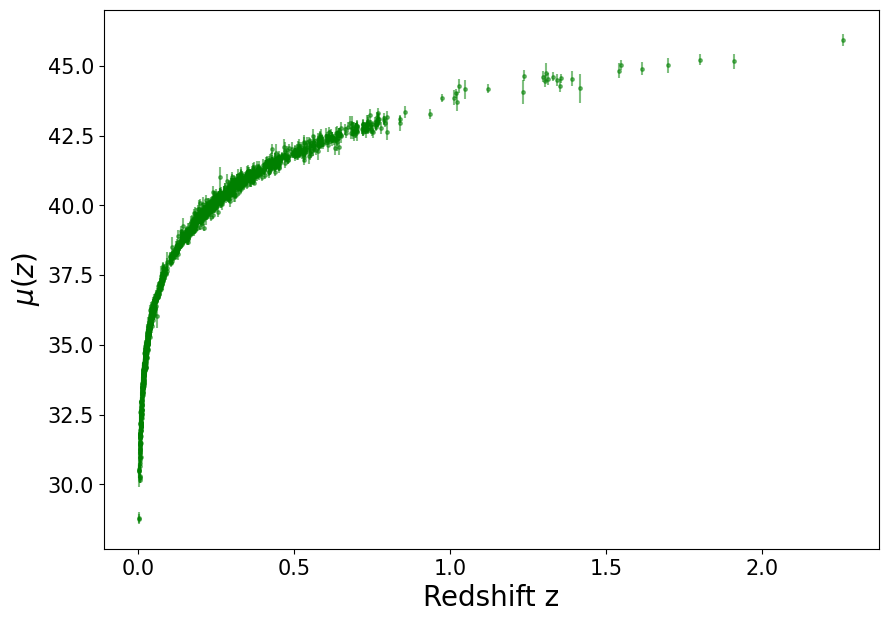

In [ ]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zHD'], df['m_b_corr'] + 19, df['errors'],
             fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel("$\mu(z)$", fontsize=20)
plt.show()

## Matern kernel - with linear z

In [ ]:
# Load mb and corresponding errors
train_y = torch.tensor(df['m_b_corr'].values)
y_err = torch.tensor(df['errors'].values)

# Load redshifts
train_x = torch.tensor(df['zHD'].values)

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=1))

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

Iter 1/200 - Loss: 1.563
Iter 2/200 - Loss: 1.510
Iter 3/200 - Loss: 1.457
Iter 4/200 - Loss: 1.402
Iter 5/200 - Loss: 1.350
Iter 6/200 - Loss: 1.294
Iter 7/200 - Loss: 1.235
Iter 8/200 - Loss: 1.178
Iter 9/200 - Loss: 1.127
Iter 10/200 - Loss: 1.068
Iter 11/200 - Loss: 1.011
Iter 12/200 - Loss: 0.957
Iter 13/200 - Loss: 0.907
Iter 14/200 - Loss: 0.852
Iter 15/200 - Loss: 0.799
Iter 16/200 - Loss: 0.745
Iter 17/200 - Loss: 0.692
Iter 18/200 - Loss: 0.639
Iter 19/200 - Loss: 0.593
Iter 20/200 - Loss: 0.542
Iter 21/200 - Loss: 0.494
Iter 22/200 - Loss: 0.440
Iter 23/200 - Loss: 0.396
Iter 24/200 - Loss: 0.358
Iter 25/200 - Loss: 0.307
Iter 26/200 - Loss: 0.248
Iter 27/200 - Loss: 0.201
Iter 28/200 - Loss: 0.147
Iter 29/200 - Loss: 0.115
Iter 30/200 - Loss: 0.068
Iter 31/200 - Loss: 0.053
Iter 32/200 - Loss: 0.031
Iter 33/200 - Loss: 0.019
Iter 34/200 - Loss: -0.022
Iter 35/200 - Loss: 0.154
Iter 36/200 - Loss: 0.208
Iter 37/200 - Loss: 0.093
Iter 38/200 - Loss: 0.146
Iter 39/200 - Loss: 

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
with torch.no_grad():
    test_x = torch.linspace(0, 2.5, 200)
    observed_pred = likelihood(model(test_x))

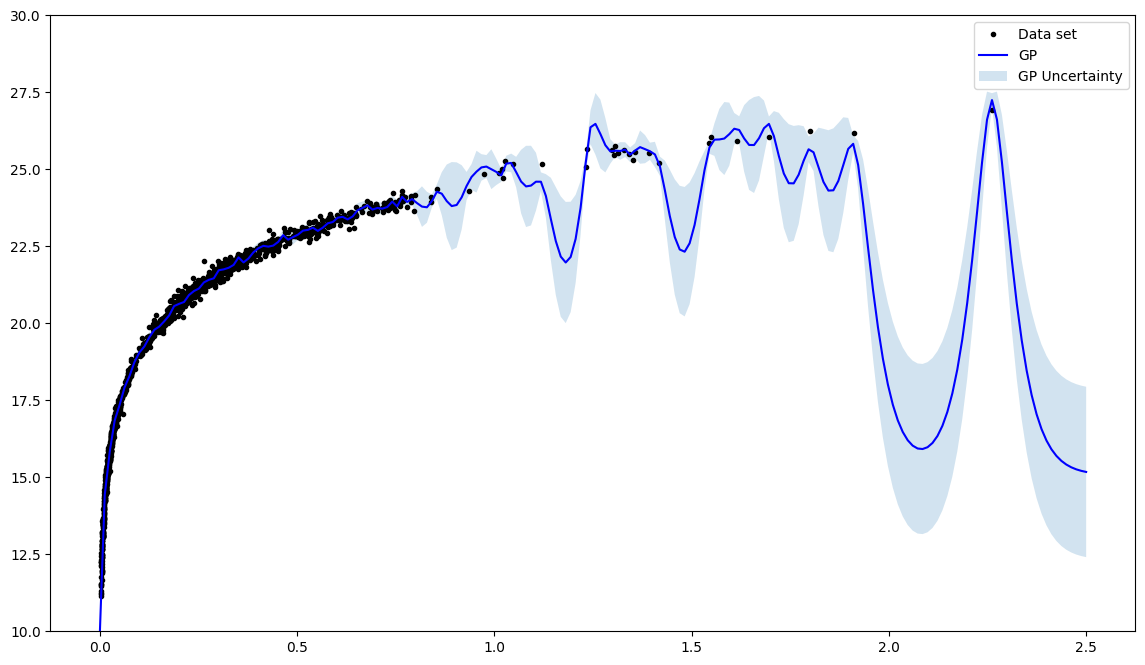

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(),
                     observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## Matern kernel - with log(z)

In [ ]:
# Load mb and corresponding errors
train_y = torch.tensor(df['m_b_corr'].values)
y_err = torch.tensor(df['errors'].values)

# Load redshifts
train_x = torch.tensor(np.log(df['zHD'].values))

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=1))

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

Iter 1/200 - Loss: 1.550
Iter 2/200 - Loss: 1.419
Iter 3/200 - Loss: 1.301
Iter 4/200 - Loss: 1.200
Iter 5/200 - Loss: 1.100
Iter 6/200 - Loss: 1.012
Iter 7/200 - Loss: 0.930
Iter 8/200 - Loss: 0.863
Iter 9/200 - Loss: 0.792
Iter 10/200 - Loss: 0.719
Iter 11/200 - Loss: 0.669
Iter 12/200 - Loss: 0.607
Iter 13/200 - Loss: 0.545
Iter 14/200 - Loss: 0.489
Iter 15/200 - Loss: 0.441
Iter 16/200 - Loss: 0.386
Iter 17/200 - Loss: 0.335
Iter 18/200 - Loss: 0.287
Iter 19/200 - Loss: 0.242
Iter 20/200 - Loss: 0.204
Iter 21/200 - Loss: 0.152
Iter 22/200 - Loss: 0.110
Iter 23/200 - Loss: 0.074
Iter 24/200 - Loss: 0.034
Iter 25/200 - Loss: -0.008
Iter 26/200 - Loss: -0.040
Iter 27/200 - Loss: -0.078
Iter 28/200 - Loss: -0.102
Iter 29/200 - Loss: -0.127
Iter 30/200 - Loss: -0.158
Iter 31/200 - Loss: -0.177
Iter 32/200 - Loss: -0.197
Iter 33/200 - Loss: -0.218
Iter 34/200 - Loss: -0.231
Iter 35/200 - Loss: -0.245
Iter 36/200 - Loss: -0.252
Iter 37/200 - Loss: -0.258
Iter 38/200 - Loss: -0.258
Iter 39

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
with torch.no_grad():
    test_x = torch.linspace(np.log(1.e-4), np.log(2.5), 200)
    observed_pred = likelihood(model(test_x))

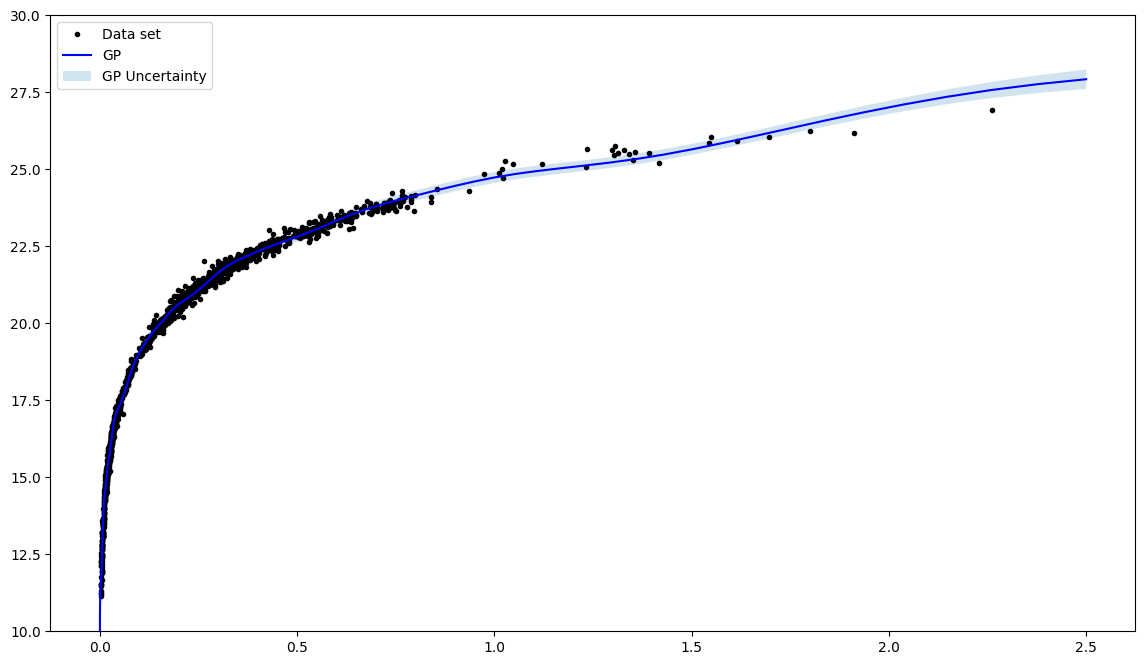

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(np.exp(train_x.numpy()), train_y.numpy(), 'k.',label='Data set')
    plt.plot(np.exp(test_x.numpy()), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(np.exp(test_x.numpy()),
                     observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## RBF kernel - linear z

In [ ]:
# Load mb and corresponding errors
train_y = torch.tensor(df['m_b_corr'].values)
y_err = torch.tensor(df['errors'].values)

# Load redshifts
train_x = torch.tensor(df['zHD'].values)

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

Iter 1/200 - Loss: 1.843
Iter 2/200 - Loss: 1.778
Iter 3/200 - Loss: 1.726
Iter 4/200 - Loss: 1.685
Iter 5/200 - Loss: 1.649
Iter 6/200 - Loss: 1.609
Iter 7/200 - Loss: 1.575
Iter 8/200 - Loss: 1.535
Iter 9/200 - Loss: 1.502
Iter 10/200 - Loss: 1.465
Iter 11/200 - Loss: 1.433
Iter 12/200 - Loss: 1.394
Iter 13/200 - Loss: 1.360
Iter 14/200 - Loss: 1.326
Iter 15/200 - Loss: 1.291
Iter 16/200 - Loss: 1.255
Iter 17/200 - Loss: 1.220
Iter 18/200 - Loss: 1.179
Iter 19/200 - Loss: 1.139
Iter 20/200 - Loss: 1.097
Iter 21/200 - Loss: 1.053
Iter 22/200 - Loss: 1.005
Iter 23/200 - Loss: 0.954
Iter 24/200 - Loss: 0.914
Iter 25/200 - Loss: 0.861
Iter 26/200 - Loss: 0.810
Iter 27/200 - Loss: 0.768
Iter 28/200 - Loss: 0.713
Iter 29/200 - Loss: 0.672
Iter 30/200 - Loss: 0.614
Iter 31/200 - Loss: 0.545
Iter 32/200 - Loss: 0.490
Iter 33/200 - Loss: 0.459
Iter 34/200 - Loss: 0.393
Iter 35/200 - Loss: 0.346
Iter 36/200 - Loss: 0.260
Iter 37/200 - Loss: 0.254
Iter 38/200 - Loss: 0.162
Iter 39/200 - Loss: 0

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
with torch.no_grad():
    test_x = torch.linspace(0, 2.5, 200)
    observed_pred = likelihood(model(test_x))

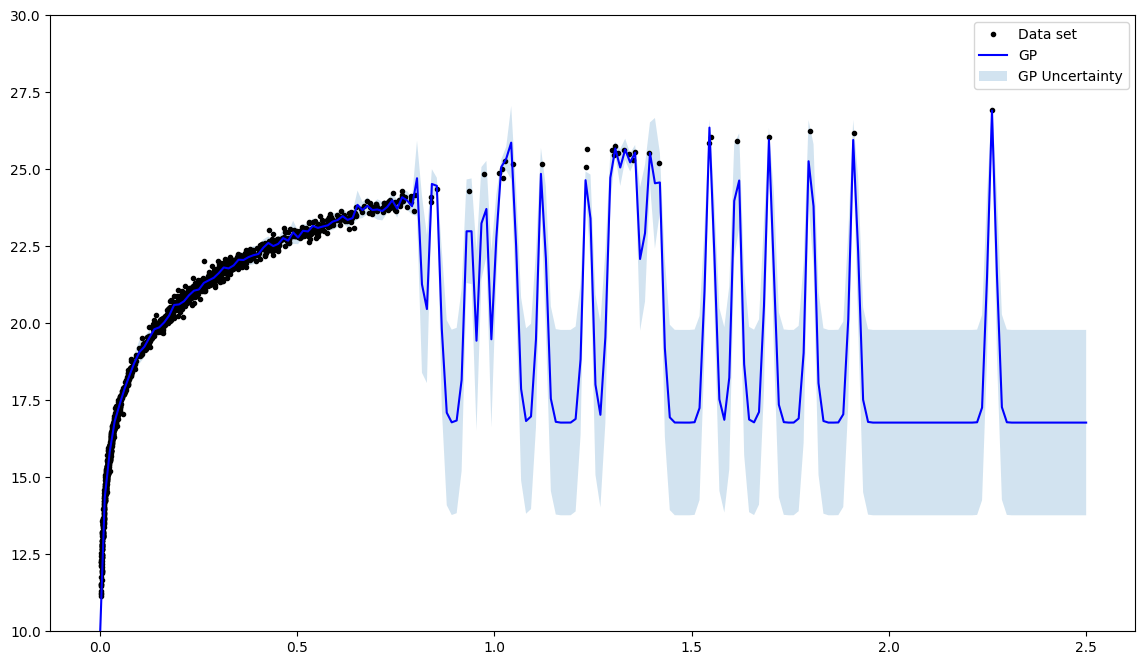

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(),
                     observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## RBF kernel - log(z)

In [ ]:
# Load mb and corresponding errors
train_y = torch.tensor(df['m_b_corr'].values)
y_err = torch.tensor(df['errors'].values)

# Load redshifts
train_x = torch.tensor(np.log(df['zHD'].values))

In [ ]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

Iter 1/200 - Loss: 1.491
Iter 2/200 - Loss: 1.362
Iter 3/200 - Loss: 1.249
Iter 4/200 - Loss: 1.154
Iter 5/200 - Loss: 1.061
Iter 6/200 - Loss: 0.981
Iter 7/200 - Loss: 0.905
Iter 8/200 - Loss: 0.833
Iter 9/200 - Loss: 0.767
Iter 10/200 - Loss: 0.703
Iter 11/200 - Loss: 0.643
Iter 12/200 - Loss: 0.581
Iter 13/200 - Loss: 0.531
Iter 14/200 - Loss: 0.473
Iter 15/200 - Loss: 0.426
Iter 16/200 - Loss: 0.376
Iter 17/200 - Loss: 0.329
Iter 18/200 - Loss: 0.281
Iter 19/200 - Loss: 0.233
Iter 20/200 - Loss: 0.192
Iter 21/200 - Loss: 0.143
Iter 22/200 - Loss: 0.103
Iter 23/200 - Loss: 0.067
Iter 24/200 - Loss: 0.028
Iter 25/200 - Loss: -0.008
Iter 26/200 - Loss: -0.043
Iter 27/200 - Loss: -0.073
Iter 28/200 - Loss: -0.100
Iter 29/200 - Loss: -0.125
Iter 30/200 - Loss: -0.155
Iter 31/200 - Loss: -0.176
Iter 32/200 - Loss: -0.193
Iter 33/200 - Loss: -0.208
Iter 34/200 - Loss: -0.220
Iter 35/200 - Loss: -0.231
Iter 36/200 - Loss: -0.239
Iter 37/200 - Loss: -0.247
Iter 38/200 - Loss: -0.250
Iter 39

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
with torch.no_grad():
    test_x = torch.linspace(np.log(1.e-4), np.log(2.5), 200)
    observed_pred = likelihood(model(test_x))

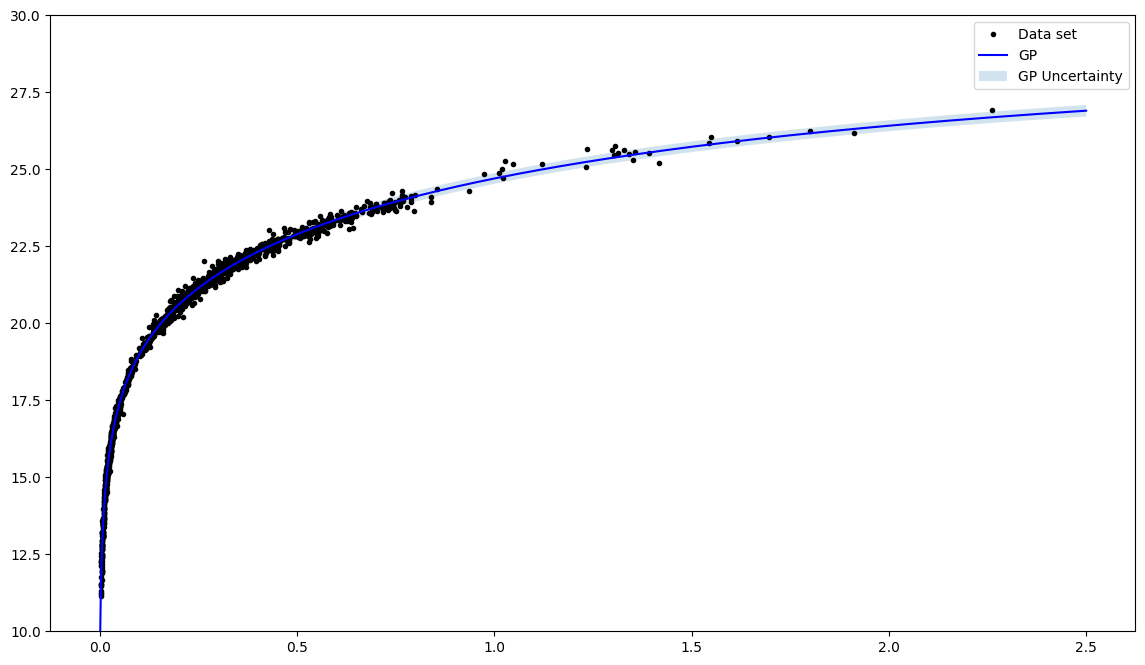

In [ ]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(np.exp(train_x.numpy()), train_y.numpy(), 'k.',label='Data set')
    plt.plot(np.exp(test_x.numpy()), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(np.exp(test_x.numpy()),
                     observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()),
                     observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()),
                     alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## Decision Trees

#### Hold out validation splits the data in two, one set to test with and the other to train with. Hold out validation is the most basic form of validation.

#### While hold-out validation is better than no validation, the measured accuracy will vary depending on how we split the data into testing and training subsets.

#### In order to be more certain of our models accuracy we should use $k$-fold cross validation. $k$-fold validation works in a similar way to hold-out except that we split the data into $k$ subsets. We train and test the model $k$ times, recording the accuracy each time. Each time we use a different combination of $k$ subsets to train the model and the final $k^{th}$ subset to test. We take the average of the $k$ accuracy measurements to be the overall accuracy of the the model.

#### The KFold library is designed to split the data into training and testing subsets. It does this by offering an iterable object that can be initialised with

#### kf = KFold(n_splits=k, shuffle=True)

#### The n_splits=k specifies the number of subsets to use.

#### By default shuffle is set to false. It is generally good practice to shuffle the data for cross validation as sometimes during collection and storage, data of a similar type can be stored adjacently which would lead to some learning bias when training the tree. For example, if the data was sorted by redshift, on the first iteration the model might be trained with redshifts 0 to 3 and tested on galaxies with redshifts ~4.

Median difference: 0.017


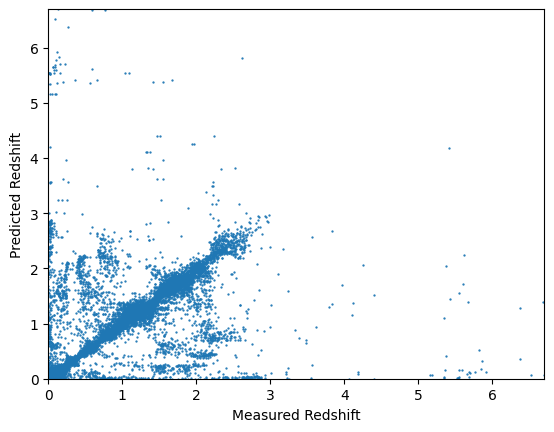

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

# your get_features_targets function here
def get_features_targets(data):
  features = np.zeros((data.shape[0], 4))
  features[:, 0] = data['u'] - data['g']
  features[:, 1] = data['g'] - data['r']
  features[:, 2] = data['r'] - data['i']
  features[:, 3] = data['i'] - data['z']
  targets = data['redshift']
  return features, targets

# your median_diff function here
def median_diff(predicted, actual):
  return np.median(np.abs(predicted - actual))

# cross_validate_predictions
def cross_validate_predictions(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  # declare an array for predicted redshifts from each iteration
  all_predictions = np.zeros_like(targets)

  for train_indices, test_indices in kf.split(features):
    # split the data into training and testing
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]

    # fit the model for the current set
    model.fit(train_features, train_targets)

    # predict using the model
    predictions = model.predict(test_features)

    # put the predicted values in the all_predictions array defined above
    all_predictions[test_indices] = predictions

  # return the predictions
  return all_predictions


if __name__ == "__main__":
  data = np.load('sdss_galaxy_colors.npy')
  features, targets = get_features_targets(data)

  # initialize model
  dtr = DecisionTreeRegressor(max_depth=19)

  # call your cross validation function
  predictions = cross_validate_predictions(dtr, features, targets, 10)

  # calculate and print the rmsd as a sanity check
  diffs = median_diff(predictions, targets)
  print('Median difference: {:.3f}'.format(diffs))

  # plot the results to see how well our model looks
  plt.scatter(targets, predictions, s=0.4)
  plt.xlim((0, targets.max()))
  plt.ylim((0, predictions.max()))
  plt.xlabel('Measured Redshift')
  plt.ylabel('Predicted Redshift')
  plt.show()

#### K-Fold cross validation is an important part of assessing the accuracy of any machine learning model. When we plotted our predicted vs measured redshifts we are able to see that for many our galaxies we were able to get a reasonably accurate prediction of redshift. However, there are also several outliers where our model does not give a good prediction.

## Artificial Neural Networks to infer model parameter contraints

ANNs are non-parametric techniques in the sense that they do not contain the cosmological parameters themselves, unlike the likelihood functions.

This may extend cosmological analyses to otherwise overly complex systems, or reduce the computational requirements of regular cosmological models analyses making the approach more accessible.

ANNs have been used in cosmology in a number of scenarios such as using Bayesian inference for calculating the power spectrum of the cosmic microwave background (CMB) and the matter power spectrum. Another useful code that has been developed to analyse CMB data is the blind accelerated multimodal Bayesian inference (BAMBI) code which uses a combination of nested sampling and ANNs to learn the actions of the likelihood function. Recently, ANNs have also been used to reconstruct the Hubble diagram and $f\sigma_8$ parameter, which may lead to an alternative way of reconstructing modified gravity instead of using Gaussian processes.

ANN architectures are also being used to learn to mimic the iterative process by which an MCMC analysis takes place.

ANNs are constructed with input and output layers to represent the MCMC parameter set that are being sampled and output likelihood respectively. These layers are connected to a series of internal, or hidden, layers that are structured in a way to optimize how closely the ANN can imitate the MCMC iterations. Each layer in this network is composed of neurons, each of which are connected to the neurons of the layers preceding and after it.


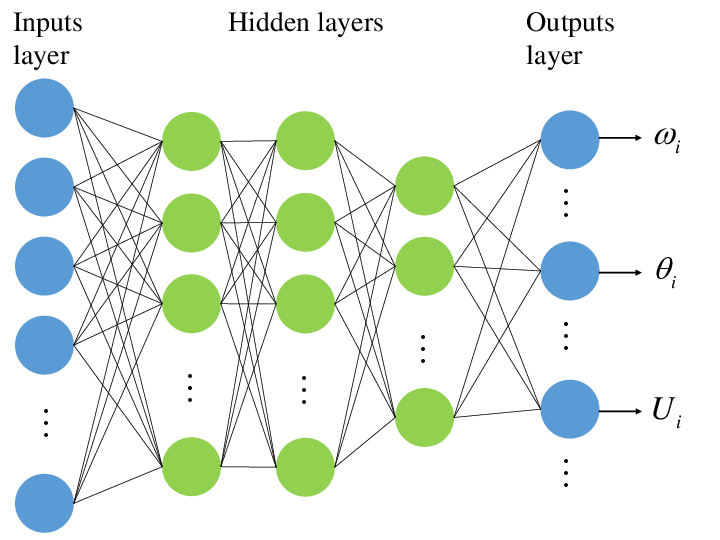

In [10]:
from IPython.display import Image
Image('figures/2306.11102_Fig1.png')

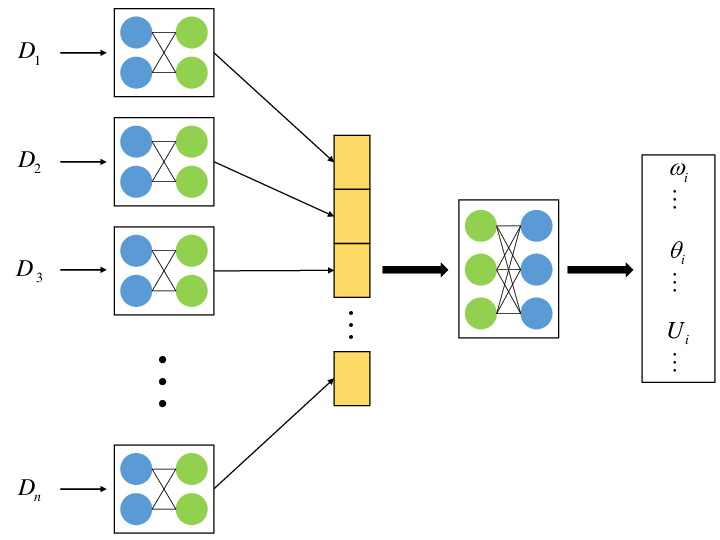

In [11]:
Image('figures/2306.11102_Fig2.png')

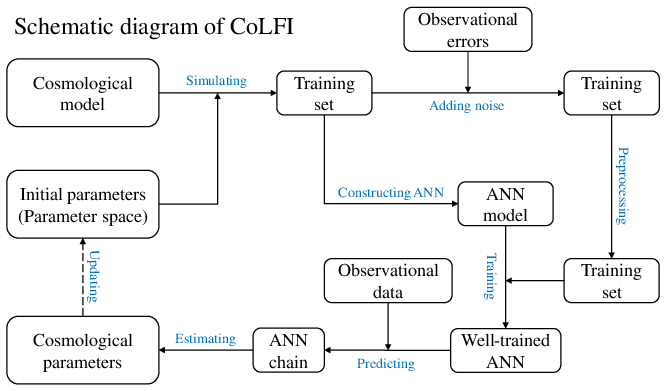

In [12]:
Image('figures/2306.11102_Fig3.png')

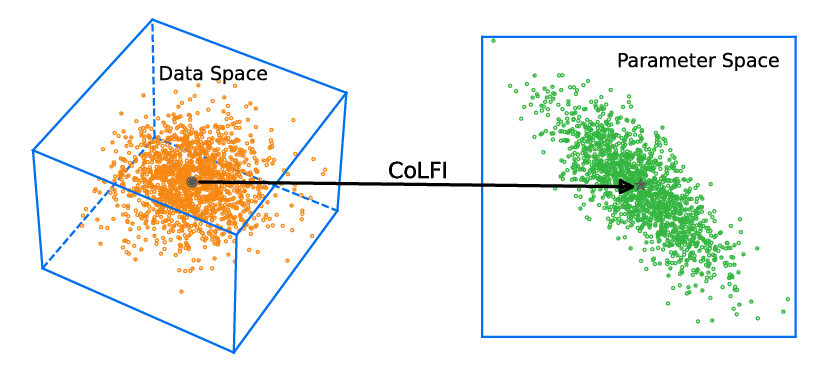

In [13]:
Image('figures/2306.11102_Fig4.png')

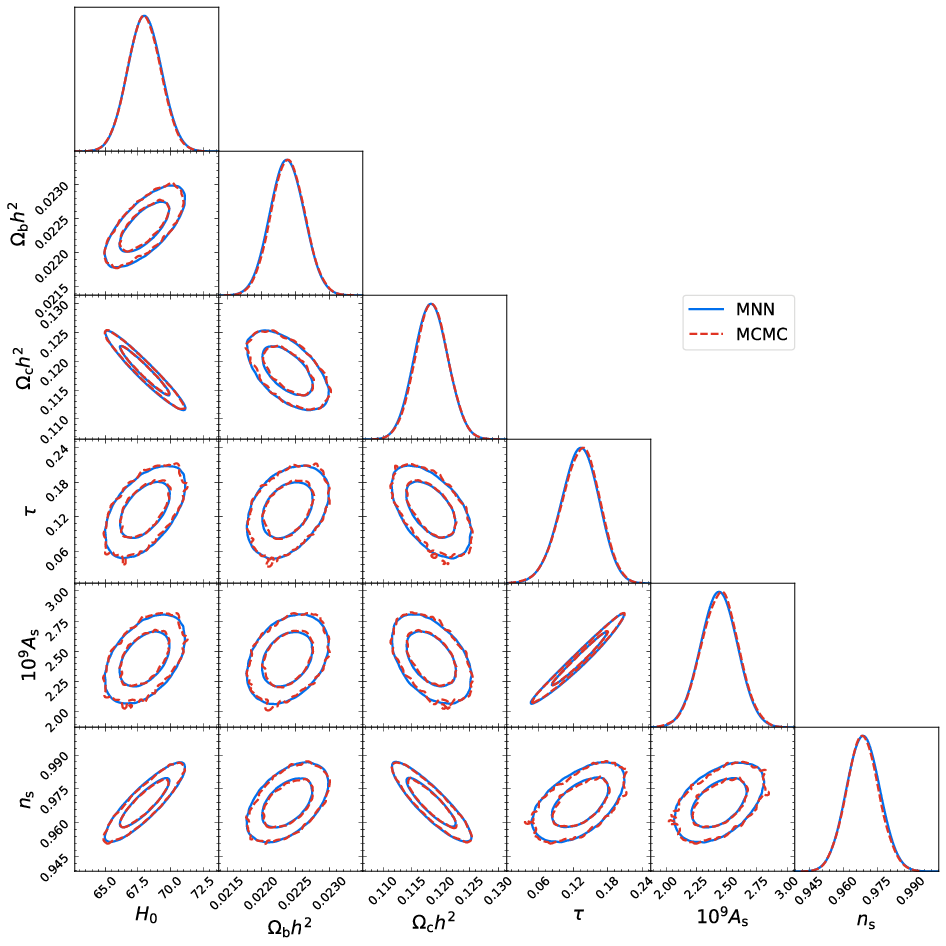

In [14]:
Image('figures/2306.11102_Fig5.png')

https://colfi.readthedocs.io/en/latest/

https://iopscience.iop.org/article/10.3847/1538-4365/ace113